In [34]:
# libraries for data manipulation and exploration
import pandas as pd
import numpy as np

# for text processing
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Conv2D, MaxPooling1D, Dropout, SimpleRNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import nltk
import tensorflow as tf
from sklearn.linear_model import Lasso
#nltk.download('wordnet')



In [6]:
data = pd.read_csv(r'/content/data.csv')
#data.head
#data.info()
# dropping rows where there is any null value
data.dropna(inplace=True, axis=0)

# taking only the name of website from the URLs
pattern = 'https?://([\w.]+)/'
data['Website'] = data.URLs.str.extract(pattern)
data.drop('URLs', axis=1, inplace=True)

# making a bar plot to count the frequency of 
# fake and real news
#sns.countplot(x='Label', 
 #             data=data,
  #            palette=['#ffaec0', '#b8b5ff'],
   #           saturation=1)
#sns.despine()
#plt.xticks([0,1], ['Fake', 'Real'])
#plt.title('Fake Vs Real news');

In [7]:
fake_news_count = data[data.Label == 0]['Website'].value_counts()
real_news_count = data[data.Label == 1]['Website'].value_counts()

fdf = pd.DataFrame({
    'Web':fake_news_count.index,
    'Fake':fake_news_count.values
})

rdf = pd.DataFrame({
    'Web':real_news_count.index,
    'Real':real_news_count.values
})

rf_count = pd.merge(rdf, fdf, on='Web', how='outer').fillna(0)
rf_count['Real'] = rf_count['Real'].astype(int)
rf_count['Fake'] = rf_count['Fake'].astype(int)
rf_count

,Web,Real,Fake
0,www.reuters.com,646,0
1,www.cnn.com,389,0
2,www.nytimes.com,341,0
3,www.bbc.com,333,0
4,abcnews.go.com,57,0
5,money.cnn.com,49,0
6,edition.cnn.com,15,0
7,inhealth.cnn.com,14,0
8,www.bbc.co.uk,10,0
9,bleacherreport.com,8,0


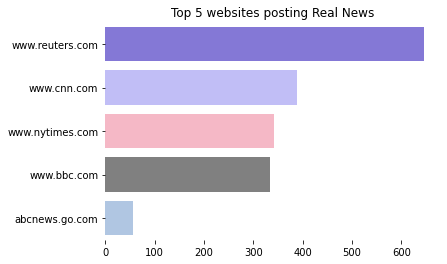

In [9]:
sns.barplot(y=real_news_count[:5].index, x=real_news_count[:5].values, 
            palette=['#7868e6', '#b8b5ff', '#ffaec0', 'grey', '#a7c5eb'])
sns.despine(bottom=True, left=True)
plt.title('Top 5 websites posting Real News');

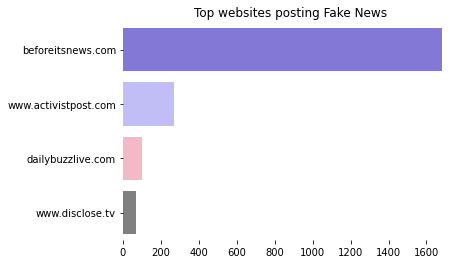

In [10]:
sns.barplot(y=fake_news_count.index, x=fake_news_count.values,
            palette=['#7868e6', '#b8b5ff', '#ffaec0', 'grey'])
sns.despine(bottom=True, left=True)
plt.title('Top websites posting Fake News');

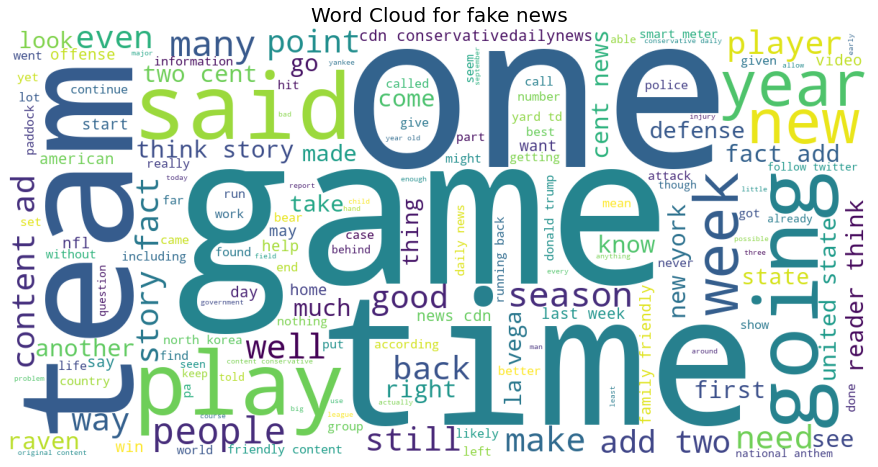

In [11]:
lm = WordNetLemmatizer()
def clean_text(column):
    corpus = []
    for value in column:
        # convert each word into lower case
        value = value.lower()
        # take only alphabets
        value = re.sub('[^a-z]', ' ', value)
        value = value.split()
        # lemmatizing those words which are not stop words
        value = [lm.lemmatize(word) for word in value\
                 if word not in set(stopwords.words('english'))]
        corpus.append(' '.join(value))
    return corpus    

# taking both headline and body of news into a single column
data['Text'] = data['Headline'] + ' ' + data['Body']
data['Text'] = clean_text(data.Text)

sw = set(STOPWORDS)

fake_news = data[data.Label == 0]
real_news = data[data.Label == 1]

# wordcloud for fake news
fake_wc = WordCloud(width = 1200, height = 600, 
                    background_color ='white', 
                    stopwords = sw, 
                    min_font_size = 10).generate(' '.join(fake_news.Text)) 
  
# plot the WordCloud image                        
plt.figure(figsize = (12, 6), facecolor = None) 
plt.imshow(fake_wc) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('Word Cloud for fake news', fontsize=20);



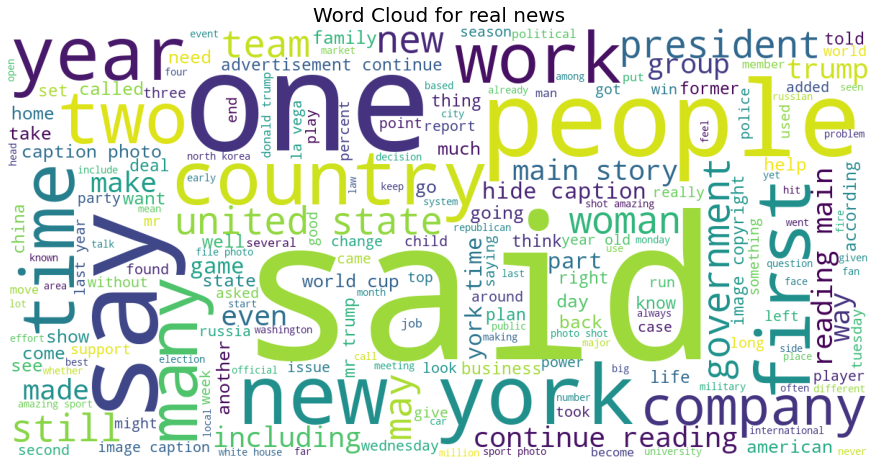

In [12]:
# wordcloud for real news
real_wc = WordCloud(width = 1200, height = 600, 
                    background_color ='white', 
                    stopwords = sw, 
                    min_font_size = 10).generate(' '.join(real_news.Text)) 
  
# plot the WordCloud image                        
plt.figure(figsize = (12, 6), facecolor = None) 
plt.imshow(real_wc) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('Word Cloud for real news', fontsize=20);

In [13]:
# one hot representation of words
oh_repr = [one_hot(words, 5000) for words in data.Text]

# list to store length of words in each news
len_list = []
for w in data.Text:
    w = w.split()
    len_list.append(len(w))

print('Summary of word length :')
pd.Series(len_list).describe()

Summary of word length :


count    3988.000000
mean      289.271063
std       289.423529
min        10.000000
25%        65.000000
50%       217.000000
75%       419.000000
max      3171.000000
dtype: float64

In [14]:
# taking sentences length as 400
sent_length = 400
# padding
embedded_doc = pad_sequences(oh_repr, padding='pre', maxlen=sent_length)
embedded_doc[:5]

array([[ 612, 3570,  303, ..., 1967, 4181, 4104],
       [   0,    0,    0, ..., 4290,  680, 2509],
       [ 350, 3260, 4427, ..., 3882,  499, 2051],
       [   0,    0,    0, ..., 1198, 3683, 4425],
       [   0,    0,    0, ..., 3391,  808, 3822]], dtype=int32)

In [15]:
x = np.array(embedded_doc)
y = data.Label


las = Lasso(alpha=1.0)
las.fit(x, y)

Lasso()

In [16]:
model = Sequential()
# adding embedding layer
model.add(Embedding(5000, 100, input_length=sent_length))
model.add(LSTM(150))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 100)          500000    
                                                                 
 lstm (LSTM)                 (None, 150)               150600    
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 650,751
Trainable params: 650,751
Non-trainable params: 0
_________________________________________________________________


In [17]:
# splitting the dataset into train and test
train_x, test_x, train_y, test_y = train_test_split(x, y, 
                                                    test_size=0.2, random_state=3)



METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
]

In [18]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS,
)

# fitting the model
history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=50, batch_size=64)

Epoch 1/50
44/44 [==============================] - 59s 1s/step - loss: 0.4554 - accuracy: 1.0000 - precision: 0.8651 - recall: 0.7686 - auc: 0.9238 - val_loss: 0.1592 - val_accuracy: 1.0000 - val_precision: 0.8920 - val_recall: 0.9909 - val_auc: 0.9885
Epoch 2/50
44/44 [==============================] - 48s 1s/step - loss: 0.0746 - accuracy: 1.0000 - precision: 0.9595 - recall: 0.9879 - auc: 0.9956 - val_loss: 0.0772 - val_accuracy: 1.0000 - val_precision: 0.9510 - val_recall: 0.9873 - val_auc: 0.9967
Epoch 3/50
44/44 [==============================] - 51s 1s/step - loss: 0.0115 - accuracy: 1.0000 - precision: 0.9955 - recall: 0.9992 - auc: 0.9999 - val_loss: 0.0681 - val_accuracy: 1.0000 - val_precision: 0.9731 - val_recall: 0.9873 - val_auc: 0.9963
Epoch 4/50
44/44 [==============================] - 48s 1s/step - loss: 0.0031 - accuracy: 1.0000 - precision: 1.0000 - recall: 0.9992 - auc: 1.0000 - val_loss: 0.0805 - val_accuracy: 1.0000 - val_precision: 0.9596 - val_recall: 0.9945 - 

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       416
           1       0.98      0.96      0.97       382

    accuracy                           0.97       798
   macro avg       0.97      0.97      0.97       798
weighted avg       0.97      0.97      0.97       798



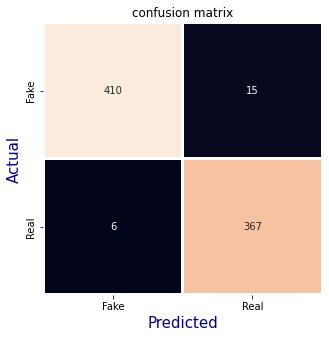

In [42]:
pred = (model.predict(test_x) > 0.5).astype("int32")

print ( classification_report(pred, test_y))

cm = confusion_matrix(test_y, pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='', cbar=False, linewidths=2,
            xticklabels = ['Fake','Real'], yticklabels = ['Fake','Real'])
plt.title('confusion matrix')
plt.xlabel('Predicted', color='navy', fontsize=15)
plt.ylabel('Actual', color='navy', fontsize=15);  

In [ ]:
#from the confusion matrix it is obvious and clear we have 416 fake news and 367 real news, it isn't imbalanced

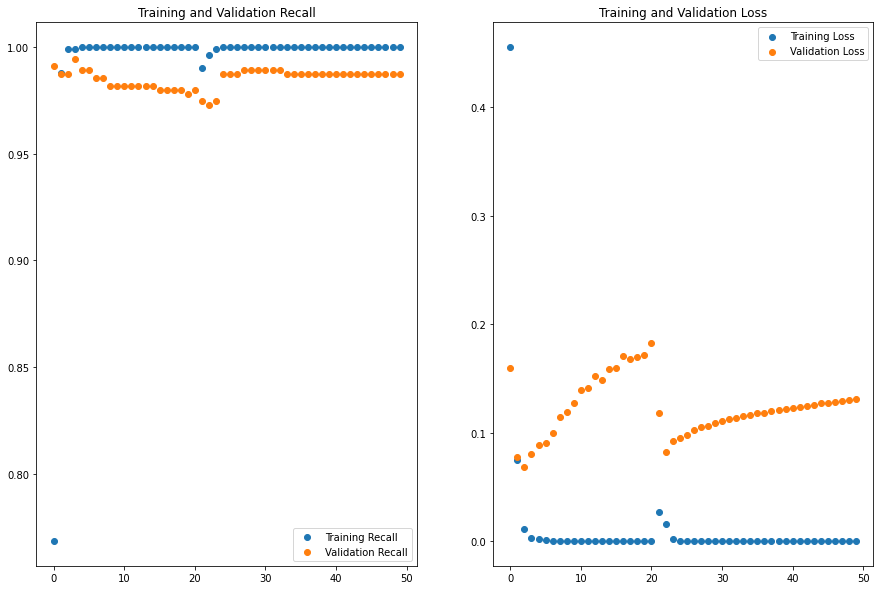

In [20]:
acc = history.history['recall']
val_acc = history.history['val_recall']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['val_loss']))
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.scatter(epochs_range, acc, label='Training Recall')
plt.scatter(epochs_range, val_acc, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')
plt.subplot(1, 2, 2)
plt.scatter(epochs_range, loss, label='Training Loss')
plt.scatter(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
# initializing model
model1 = Sequential()
# adding embedding layer
model1.add(Embedding(5000, 100, input_length=sent_length))
model1.add(Conv1D(filters=28,kernel_size=7,activation='relu'))
MaxPooling1D(pool_size=2) 
Dropout(0.3)
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 400, 100)          500000    
                                                                 
 conv1d_1 (Conv1D)           (None, 394, 28)           19628     
                                                                 
 dense_2 (Dense)             (None, 394, 1)            29        
                                                                 
Total params: 519,657
Trainable params: 519,657
Non-trainable params: 0
_________________________________________________________________


In [32]:
model1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS,
)

In [40]:
# fitting the model
history = model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=50, batch_size=64)

Epoch 1/50
50/50 [==============================] - 57s 1s/step - loss: 0.0195 - accuracy: 1.0000 - precision: 0.9953 - recall: 0.9933 - auc: 0.9988 - val_loss: 0.1536 - val_accuracy: 1.0000 - val_precision: 0.9603 - val_recall: 0.9732 - val_auc: 0.9857
Epoch 2/50
50/50 [==============================] - 54s 1s/step - loss: 0.0045 - accuracy: 1.0000 - precision: 0.9993 - recall: 0.9993 - auc: 0.9997 - val_loss: 0.1290 - val_accuracy: 1.0000 - val_precision: 0.9730 - val_recall: 0.9651 - val_auc: 0.9862
Epoch 3/50
50/50 [==============================] - 52s 1s/step - loss: 3.9099e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.1344 - val_accuracy: 1.0000 - val_precision: 0.9628 - val_recall: 0.9705 - val_auc: 0.9873
Epoch 4/50
50/50 [==============================] - 53s 1s/step - loss: 1.7724e-04 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 0.1401 - val_accuracy: 1.0000 - val_precision: 0.9603 - val_recall: 0

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       414
           1       0.99      0.96      0.97       384

    accuracy                           0.97       798
   macro avg       0.97      0.97      0.97       798
weighted avg       0.97      0.97      0.97       798



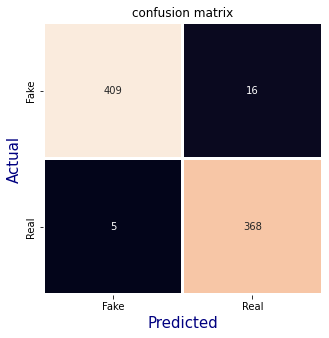

In [41]:
pred1 = (model1.predict(test_x) > 0.5).astype("int32")

print ( classification_report(pred, test_y))

cm = confusion_matrix(test_y, pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='', cbar=False, linewidths=2,
            xticklabels = ['Fake','Real'], yticklabels = ['Fake','Real'])
plt.title('confusion matrix')
plt.xlabel('Predicted', color='navy', fontsize=15)
plt.ylabel('Actual', color='navy', fontsize=15);

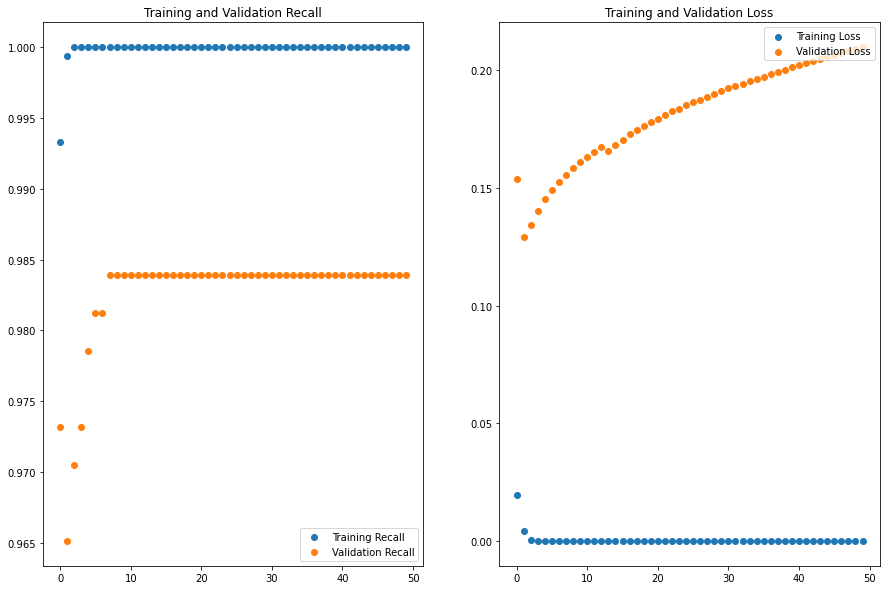

In [43]:
acc = history.history['recall']
val_acc = history.history['val_recall']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['val_loss']))
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.scatter(epochs_range, acc, label='Training Recall')
plt.scatter(epochs_range, val_acc, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')
plt.subplot(1, 2, 2)
plt.scatter(epochs_range, loss, label='Training Loss')
plt.scatter(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [35]:
model3 = Sequential()
# adding embedding layer
model3.add(Embedding(5000, 100, input_length=sent_length))
model3.add(SimpleRNN(150))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 400, 100)          500000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 150)               37650     
                                                                 
 dense_3 (Dense)             (None, 1)                 151       
                                                                 
Total params: 537,801
Trainable params: 537,801
Non-trainable params: 0
_________________________________________________________________


In [36]:
# splitting the dataset into train and test
train_x, test_x, train_y, test_y = train_test_split(x, y, 
                                                    test_size=0.2, random_state=3)



METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
]

In [37]:
model3.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=METRICS,
)

# fitting the model
history = model3.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=50, batch_size=64)

Epoch 1/50
50/50 [==============================] - 19s 325ms/step - loss: 0.5141 - accuracy: 1.0000 - precision: 0.7516 - recall: 0.7064 - auc: 0.8525 - val_loss: 0.3980 - val_accuracy: 1.0000 - val_precision: 0.8693 - val_recall: 0.8740 - val_auc: 0.9555
Epoch 2/50
50/50 [==============================] - 15s 306ms/step - loss: 0.1693 - accuracy: 1.0000 - precision: 0.9348 - recall: 0.9679 - auc: 0.9841 - val_loss: 0.1089 - val_accuracy: 1.0000 - val_precision: 0.9340 - val_recall: 0.9866 - val_auc: 0.9927
Epoch 3/50
50/50 [==============================] - 15s 308ms/step - loss: 0.0395 - accuracy: 1.0000 - precision: 0.9821 - recall: 0.9920 - auc: 0.9993 - val_loss: 0.0856 - val_accuracy: 1.0000 - val_precision: 0.9602 - val_recall: 0.9705 - val_auc: 0.9937
Epoch 4/50
50/50 [==============================] - 15s 306ms/step - loss: 0.0447 - accuracy: 1.0000 - precision: 0.9899 - recall: 0.9880 - auc: 0.9993 - val_loss: 0.0998 - val_accuracy: 1.0000 - val_precision: 0.9580 - val_recal

              precision    recall  f1-score   support

           0       0.96      0.99      0.97       414
           1       0.99      0.96      0.97       384

    accuracy                           0.97       798
   macro avg       0.97      0.97      0.97       798
weighted avg       0.97      0.97      0.97       798



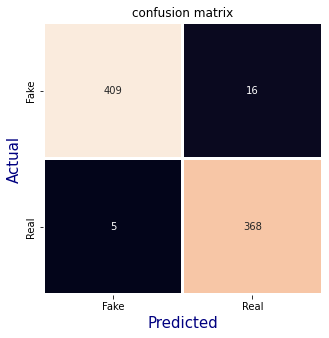

In [38]:
pred = (model.predict(test_x) > 0.5).astype("int32")

print ( classification_report(pred, test_y))

cm = confusion_matrix(test_y, pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='', cbar=False, linewidths=2,
            xticklabels = ['Fake','Real'], yticklabels = ['Fake','Real'])
plt.title('confusion matrix')
plt.xlabel('Predicted', color='navy', fontsize=15)
plt.ylabel('Actual', color='navy', fontsize=15); 

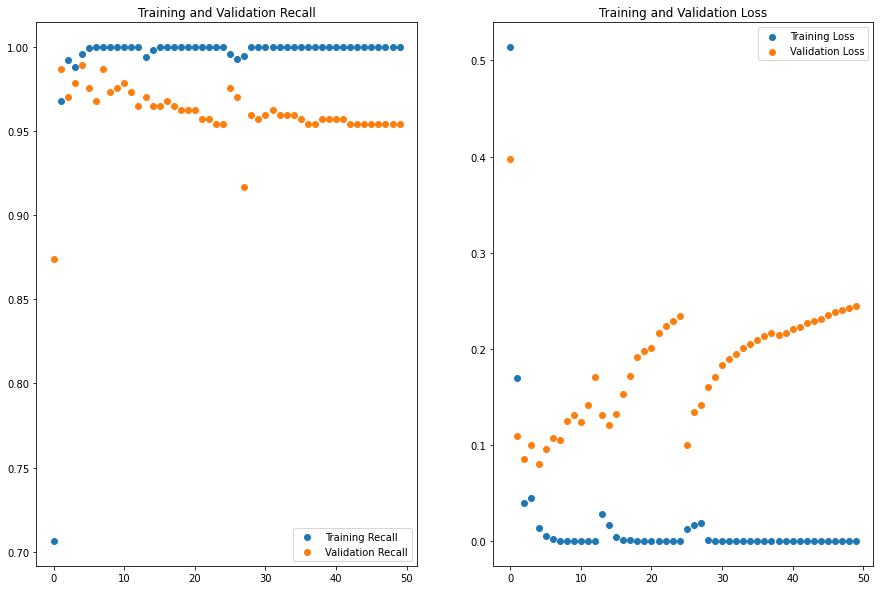

In [39]:
acc = history.history['recall']
val_acc = history.history['val_recall']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['val_loss']))
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.scatter(epochs_range, acc, label='Training Recall')
plt.scatter(epochs_range, val_acc, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')
plt.subplot(1, 2, 2)
plt.scatter(epochs_range, loss, label='Training Loss')
plt.scatter(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()